<a href="https://colab.research.google.com/github/coderford/pytorch_pruning/blob/main/PyTorch_Pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Pruning with PyTorch

In this notebook, we'll implement some neural network pruning methods using PyTorch and test the Lottery Ticket Hypothesis too. We'll be using the LeNet5 architecture, and the MNIST, FashionMNIST and CIFAR10 datasets.

## Imports and stuff

In [1]:
import copy

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.utils.prune as prune

from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Dataset imports
from torchvision.datasets import FashionMNIST
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10

## The LeNet Architecture

The LeNet5 architecture was proposed for the MNIST dataset. The layers are as follows:

1. Conv2d with 1 input channel, 6 output channels, 5x5 kernel, 2 padding
2. MaxPool  with 2x2 kernel. _Note_: In the original paper, it was a different, subsampling layer. However we'll use max pooling for simplicity
3. Conv2d with 6 input channels, 16 output channels, 5x5 kernel, 0 padding
4. MaxPool with 2x2 kernel.
5. Fully connected layer with 120 outputs
6. Fully connected layer with 84 outputs
7. Fully connected layer with 10 outputs

In [3]:
class LeNet5(nn.Module):
  def __init__(self, input_channels, input_side):
    super(LeNet5, self).__init__()
    self.input_channels = input_channels
    self.input_side = input_side
    self.fc_input_size = self.calc_fc_input_side(self.input_side)

    # layers
    self.conv1 = nn.Conv2d(self.input_channels, 6, 3)
    self.conv2 = nn.Conv2d(6, 16, 3)
    self.fc1   = nn.Linear(self.fc_input_size, 120)   
    self.fc2   = nn.Linear(120, 84)
    self.fc3   = nn.Linear(84, 10)

  def calc_fc_input_side(self, orig_side):
    # first, kernel of size 3, 1 stride, 0 padding applied
    side = orig_side - 3 + 1
    # then, maxpool2d with kernel of size 2, stride 2
    side = side // 2 
    # again, kernel of size 3 applied
    side = side - 3 + 1
    # again, maxpool2d with kernel of size 2, stride 2
    side = side // 2
    # input to fc layer will be 16 * side * side
    return 16 * side * side

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), 2)
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = x.view(-1, int(x.nelement() / x.shape[0]))   # Flatten (the batch!)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)                                  # Why no ReLU? -> would be softmax, but we'll be using cross_entropy... so it works
    return x

## Hyperparameters

In [4]:
# Hyperparameters
lr         = 0.001
opt_fn     = optim.Adam
n_epochs   = 20
loss_fn    = F.cross_entropy
batch_size = 128

## Data Preparation

In this section we'll define some helper functions for loading our datasets. These will be used in the next sections to actually load the data.

In [5]:
def split_train_dataset(dataset, val_frac=0.2):
  '''
  Helper function for splitting training function int train and validation sets
  '''
  n_samples = len(train_dataset)
  n_val     = int(n_samples * val_frac)
  n_train   = n_samples - n_val

  train_dataset, val_dataset = random_split(train_dataset, [n_train, n_val])
  return train_dataset, val_dataset

In [6]:
def load_dataset(torchvision_dataset, split_train=True):
  '''
  Helper function to load a dataset available in torchvision.datasets
  '''
  train_dataset = torchvision_dataset(
      root='data/',
      train=True,
      download=True,
      transform=torchvision.transforms.ToTensor(),
  )

  test_dataset = torchvision_dataset(
      root='data/',
      train=False, 
      download=True,
      transform=torchvision.transforms.ToTensor() 
  )

  if split_train:
    train_dataset, val_dataset = split_train_dataset(train_dataset)
    return train_dataset, val_dataset, test_dataset

  # If splitting was not required, return on train and test sets
  return train_dataset, test_dataset

In [ ]:
# Init MNIST data
mnist_train, mnist_test = load_dataset(MNIST, split_train=False)
mnist_train_loader = DataLoader(mnist_train, batch_size=batch_size)
mnist_test_loader  = DataLoader(mnist_test,  batch_size=len(mnist_test))

In [ ]:
# Init Fashion-MNIST data
fmnist_train, fmnist_test = load_dataset(FashionMNIST, split_train=False)
fmnist_train_loader = DataLoader(fmnist_train, batch_size=batch_size)
fmnist_test_loader  = DataLoader(fmnist_test,  batch_size=len(fmnist_test))

In [ ]:
# Init CIFAR10 data
cifar10_train, cifar10_test = load_dataset(CIFAR10, split_train=False)
cifar10_train_loader = DataLoader(cifar10_train, batch_size=batch_size)
cifar10_test_loader  = DataLoader(cifar10_test,  batch_size=len(cifar10_test))

## Utility Functions

Here are several utility functions we'll be using throughout the notebook.

In [10]:
def count_model_params(model):
  count = 0
  for p in model.parameters():
    count += len(p.view(-1))
  return count

In [11]:
def test_accuracy(model, test_loader):
  '''
  Returns accuracy on test dataset. Assumes that test_loader has single batch
  containing the whole test dataset.
  '''
  acc = -1
  for images, labels in test_loader:
    images = images.to(device)
    preds = torch.argmax(model(images.to(device=device)), axis=1)
    correct_count = torch.sum((preds == labels.to(device=device)).float())
    acc = correct_count.item()/ len(preds)
    break
  return acc

In [12]:
def calculate_sparsity(model):
  total0 = 0
  total  = 0
  for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
      total0 += torch.sum(module.weight == 0).cpu().detach().item()
      total  += module.weight.nelement()
  return total0 / total

In [13]:
def plot_prune_histories(histories, labels, title=None):
  for history, label in zip(histories, labels):
    plt.plot([x[0] for x in history], [x[1] for x in history], label=label)
  plt.xlabel('Sparsity')
  plt.title(title)
  plt.ylabel('Test Accuracy')
  if(len(labels) > 1):
    plt.legend()
  plt.show()

## Training

### Fit Function

As usual, we'll define a `fit` function for training our model

In [14]:
def fit(model, dloader, n_epochs, opt_fn, loss_fn, lr=0.01, print_every=1):
  opt = opt_fn(model.parameters(), lr)
  loss_history = []

  for epoch in range(n_epochs):
    total_loss = 0
    n_batches  = 0

    for xb, yb in dloader:
      xb, yb = xb.to(device), yb.to(device)
      preds = model(xb)
      loss  = loss_fn(preds, yb)
      loss.backward()

      total_loss += loss.item()
      n_batches  += 1

      opt.step()
      opt.zero_grad()

    avg_loss = total_loss / n_batches
    loss_history.append(avg_loss)
    if (epoch + 1) % print_every == 0:
      print("Epoch [{}/{}]. \tAverage loss: {:.4f}".format(epoch+1, n_epochs, avg_loss))

### MNIST

In [ ]:
# Init model
mnist_model = LeNet5(1, 28).to(device)

# Print a count of the number of parameters
print('Parameters in LeNet for MNIST:', count_model_params(mnist_model))

Parameters in LeNet for MNIST: 60074


In [ ]:
# Train
fit(mnist_model, mnist_train_loader, n_epochs, opt_fn, loss_fn, lr=lr)

Epoch [1/20]. 	Average loss: 0.5448
Epoch [2/20]. 	Average loss: 0.1502
Epoch [3/20]. 	Average loss: 0.1003
Epoch [4/20]. 	Average loss: 0.0776
Epoch [5/20]. 	Average loss: 0.0642
Epoch [6/20]. 	Average loss: 0.0545
Epoch [7/20]. 	Average loss: 0.0475
Epoch [8/20]. 	Average loss: 0.0423
Epoch [9/20]. 	Average loss: 0.0371
Epoch [10/20]. 	Average loss: 0.0324
Epoch [11/20]. 	Average loss: 0.0288
Epoch [12/20]. 	Average loss: 0.0261
Epoch [13/20]. 	Average loss: 0.0227
Epoch [14/20]. 	Average loss: 0.0201
Epoch [15/20]. 	Average loss: 0.0186
Epoch [16/20]. 	Average loss: 0.0175
Epoch [17/20]. 	Average loss: 0.0158
Epoch [18/20]. 	Average loss: 0.0150
Epoch [19/20]. 	Average loss: 0.0124
Epoch [20/20]. 	Average loss: 0.0127


In [ ]:
# Let's try it on the test set:
print(f'MNIST Test accuracy: {100*test_accuracy(mnist_model, mnist_test_loader):.2f}%')

MNIST Test accuracy: 98.61%


Before moving on to pruning, let's save this trained model, just so we won't have to train it again in case we destroy it during pruning.

In [ ]:
torch.save(mnist_model, 'LeNet_MNIST.pt')

### Fashion-MNIST

In [ ]:
# Init model
fmnist_model = LeNet5(1, 28).to(device)

# Print a count of the number of parameters
print('Parameters in LeNet for F-MNIST:', count_model_params(fmnist_model))

Parameters in LeNet for F-MNIST: 60074


In [ ]:
# Train
fit(fmnist_model, fmnist_train_loader, n_epochs, opt_fn, loss_fn, lr=lr)

Epoch [1/20]. 	Average loss: 0.8170
Epoch [2/20]. 	Average loss: 0.5008
Epoch [3/20]. 	Average loss: 0.4380
Epoch [4/20]. 	Average loss: 0.3969
Epoch [5/20]. 	Average loss: 0.3693
Epoch [6/20]. 	Average loss: 0.3487
Epoch [7/20]. 	Average loss: 0.3319
Epoch [8/20]. 	Average loss: 0.3183
Epoch [9/20]. 	Average loss: 0.3064
Epoch [10/20]. 	Average loss: 0.2966
Epoch [11/20]. 	Average loss: 0.2880
Epoch [12/20]. 	Average loss: 0.2804
Epoch [13/20]. 	Average loss: 0.2731
Epoch [14/20]. 	Average loss: 0.2659
Epoch [15/20]. 	Average loss: 0.2597
Epoch [16/20]. 	Average loss: 0.2536
Epoch [17/20]. 	Average loss: 0.2480
Epoch [18/20]. 	Average loss: 0.2428
Epoch [19/20]. 	Average loss: 0.2376
Epoch [20/20]. 	Average loss: 0.2325


In [ ]:
# Let's try it on the test set
print(f'F-MNIST Test accuracy: {100*test_accuracy(fmnist_model, fmnist_test_loader):.2f}%')

F-MNIST Test accuracy: 88.80%


In [ ]:
torch.save(fmnist_model, 'LeNet_FMNIST.pt')

### CIFAR-10

In [ ]:
# Init model
cifar10_model = LeNet5(3, 32).to(device)

# Print a count of the number of parameters
print('Parameters in LeNet for CIFAR10:', count_model_params(cifar10_model))

Parameters in LeNet for CIFAR10: 81302


In [ ]:
# For CIFAR10, we'll train for 50 itertions
fit(cifar10_model, cifar10_train_loader, 50, opt_fn, loss_fn, lr=lr)

Epoch [1/50]. 	Average loss: 1.8658
Epoch [2/50]. 	Average loss: 1.6052
Epoch [3/50]. 	Average loss: 1.4953
Epoch [4/50]. 	Average loss: 1.3996
Epoch [5/50]. 	Average loss: 1.3140
Epoch [6/50]. 	Average loss: 1.2440
Epoch [7/50]. 	Average loss: 1.1905
Epoch [8/50]. 	Average loss: 1.1466
Epoch [9/50]. 	Average loss: 1.1100
Epoch [10/50]. 	Average loss: 1.0787
Epoch [11/50]. 	Average loss: 1.0524
Epoch [12/50]. 	Average loss: 1.0290
Epoch [13/50]. 	Average loss: 1.0070
Epoch [14/50]. 	Average loss: 0.9874
Epoch [15/50]. 	Average loss: 0.9693
Epoch [16/50]. 	Average loss: 0.9533
Epoch [17/50]. 	Average loss: 0.9385
Epoch [18/50]. 	Average loss: 0.9216
Epoch [19/50]. 	Average loss: 0.9070
Epoch [20/50]. 	Average loss: 0.8923
Epoch [21/50]. 	Average loss: 0.8785
Epoch [22/50]. 	Average loss: 0.8654
Epoch [23/50]. 	Average loss: 0.8542
Epoch [24/50]. 	Average loss: 0.8415
Epoch [25/50]. 	Average loss: 0.8304
Epoch [26/50]. 	Average loss: 0.8193
Epoch [27/50]. 	Average loss: 0.8093
Epoch [28/

In [ ]:
# Let's try it on the test set
print(f'CIFAR-10 Test accuracy: {100*test_accuracy(cifar10_model, cifar10_test_loader):.2f}%')

CIFAR-10 Test accuracy: 61.76%


In [ ]:
torch.save(cifar10_model, 'LeNet_CIFAR10.pt')

## Magnitude Based Pruning

With a trained model in hand, let's get to pruning proper. We'll perform global pruning, since that seems to work best in most cases.



### Functions

In [20]:
def get_parameters_to_prune(model):
  params = []
  for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
      params.append((module, 'weight'))
  return params

In [21]:
def prune_gradually(model, method, test_loader, importance_scores=None, prune_frac=0.1, sparsity_threshold=0.01):
  history = []
  history.append((0, test_accuracy(model, test_loader)))

  parameters_to_prune = get_parameters_to_prune(model)
  while 1 - calculate_sparsity(model) > sparsity_threshold:
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=method,
        importance_scores=importance_scores,
        amount=prune_frac,  
    )

    acc = test_accuracy(model, test_loader)
    sparsity = calculate_sparsity(model)
    print("At %.2f"%(100*sparsity)+"%"+" sparsity, accuracy is %.2f"%(100*acc)+"%")
    history.append((sparsity, acc))
  
  return history

We'll prune the model gradually (10% at a time), and keep track of the test performance.

### Custom pruning class

In [18]:
class MyL1PruningMethod(prune.BasePruningMethod):
  '''
  Prunes 'amount' fraction of weights with lowest magnitude
  '''
  PRUNING_TYPE = 'unstructured'

  def __init__(self, amount):
    self.amount = amount

  def compute_mask(self, t, default_mask):
    # Note: t is the tensor of importance scores, equal to the parameters by default

    n_prune = int(self.amount * t.nelement())
    _, prune_indices = torch.topk(torch.abs(t).view(-1), k=n_prune, largest=False)

    mask = default_mask.clone()
    mask.view(-1)[prune_indices] = 0
    return mask

### MNIST

In [ ]:
mnist_model = torch.load('LeNet_MNIST.pt').to(device)

In [ ]:
mnist_prune_history = prune_gradually(
    mnist_model, 
    MyL1PruningMethod, 
    mnist_test_loader, 
    prune_frac=0.1, 
    sparsity_threshold=0.05
)

At 10.00% sparsity, accuracy is 98.58%
At 19.00% sparsity, accuracy is 98.59%
At 27.10% sparsity, accuracy is 98.60%
At 34.39% sparsity, accuracy is 98.60%
At 40.95% sparsity, accuracy is 98.51%
At 46.85% sparsity, accuracy is 98.57%
At 52.17% sparsity, accuracy is 98.69%
At 56.95% sparsity, accuracy is 98.62%
At 61.26% sparsity, accuracy is 98.56%
At 65.13% sparsity, accuracy is 98.47%
At 68.62% sparsity, accuracy is 98.40%
At 71.75% sparsity, accuracy is 98.51%
At 74.58% sparsity, accuracy is 98.28%
At 77.12% sparsity, accuracy is 98.25%
At 79.41% sparsity, accuracy is 97.91%
At 81.47% sparsity, accuracy is 97.71%
At 83.32% sparsity, accuracy is 96.74%
At 84.99% sparsity, accuracy is 95.47%
At 86.49% sparsity, accuracy is 94.47%
At 87.84% sparsity, accuracy is 91.82%
At 89.05% sparsity, accuracy is 87.00%
At 90.15% sparsity, accuracy is 89.62%
At 91.13% sparsity, accuracy is 76.59%
At 92.02% sparsity, accuracy is 73.05%
At 92.82% sparsity, accuracy is 61.22%
At 93.53% sparsity, accur

In [ ]:
torch.save(mnist_prune_history, 'mnist_prune_history.pkl')

Let's make a graph to see how quickly accuracy drops with increasing sparsity:

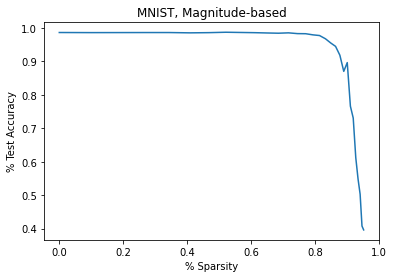

In [ ]:
plot_prune_histories([mnist_prune_history], ['MNIST'], title='MNIST, Magnitude-based')

### Fashion-MNIST

In [ ]:
fmnist_model = torch.load('LeNet_FMNIST.pt').to(device)

In [ ]:
fmnist_prune_history = prune_gradually(
    fmnist_model, 
    MyL1PruningMethod, 
    fmnist_test_loader, 
    prune_frac=0.1, 
    sparsity_threshold=0.05
)

At 10.00% sparsity, accuracy is 88.78%
At 19.00% sparsity, accuracy is 88.80%
At 27.10% sparsity, accuracy is 88.80%
At 34.39% sparsity, accuracy is 88.73%
At 40.95% sparsity, accuracy is 88.54%
At 46.85% sparsity, accuracy is 88.25%
At 52.17% sparsity, accuracy is 87.80%
At 56.95% sparsity, accuracy is 87.86%
At 61.26% sparsity, accuracy is 86.31%
At 65.13% sparsity, accuracy is 86.74%
At 68.62% sparsity, accuracy is 86.09%
At 71.75% sparsity, accuracy is 85.42%
At 74.58% sparsity, accuracy is 85.87%
At 77.12% sparsity, accuracy is 85.23%
At 79.41% sparsity, accuracy is 82.25%
At 81.47% sparsity, accuracy is 80.25%
At 83.32% sparsity, accuracy is 77.66%
At 84.99% sparsity, accuracy is 71.95%
At 86.49% sparsity, accuracy is 72.60%
At 87.84% sparsity, accuracy is 66.24%
At 89.05% sparsity, accuracy is 61.59%
At 90.15% sparsity, accuracy is 61.21%
At 91.13% sparsity, accuracy is 61.50%
At 92.02% sparsity, accuracy is 55.36%
At 92.82% sparsity, accuracy is 35.71%
At 93.53% sparsity, accur

In [ ]:
torch.save(fmnist_prune_history, 'fmnist_prune_history.pkl')

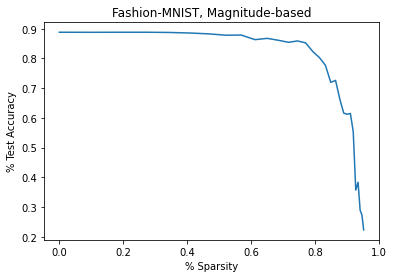

In [ ]:
plot_prune_histories([fmnist_prune_history], ['Fashion-MNIST'], title='Fashion-MNIST, Magnitude-based')

### CIFAR10

In [ ]:
cifar10_model = torch.load('LeNet_CIFAR10.pt').to(device)

In [ ]:
cifar10_prune_history = prune_gradually(
    cifar10_model, 
    MyL1PruningMethod, 
    cifar10_test_loader, 
    prune_frac=0.1, 
    sparsity_threshold=0.05
)

At 10.00% sparsity, accuracy is 61.79%
At 19.00% sparsity, accuracy is 61.25%
At 27.10% sparsity, accuracy is 61.74%
At 34.39% sparsity, accuracy is 61.71%
At 40.95% sparsity, accuracy is 62.45%
At 46.85% sparsity, accuracy is 61.80%
At 52.17% sparsity, accuracy is 59.01%
At 56.95% sparsity, accuracy is 59.23%
At 61.25% sparsity, accuracy is 58.44%
At 65.13% sparsity, accuracy is 56.74%
At 68.61% sparsity, accuracy is 54.39%
At 71.75% sparsity, accuracy is 48.84%
At 74.58% sparsity, accuracy is 42.37%
At 77.12% sparsity, accuracy is 42.73%
At 79.41% sparsity, accuracy is 30.44%
At 81.46% sparsity, accuracy is 20.46%
At 83.32% sparsity, accuracy is 15.94%
At 84.99% sparsity, accuracy is 13.96%
At 86.49% sparsity, accuracy is 16.14%
At 87.84% sparsity, accuracy is 13.86%
At 89.05% sparsity, accuracy is 14.74%
At 90.15% sparsity, accuracy is 12.38%
At 91.13% sparsity, accuracy is 12.53%
At 92.02% sparsity, accuracy is 12.41%
At 92.82% sparsity, accuracy is 10.17%
At 93.53% sparsity, accur

In [ ]:
torch.save(cifar10_prune_history, 'cifar10_prune_history.pkl')

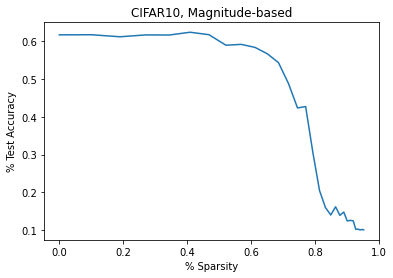

In [ ]:
plot_prune_histories([cifar10_prune_history], ['CIFAR10'], title='CIFAR10, Magnitude-based')

Accuracy falls off even faster here.

### All three

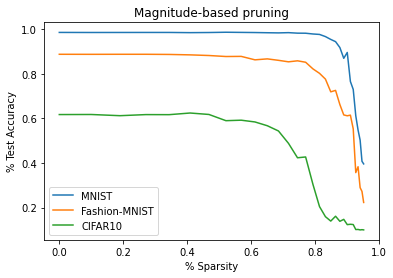

In [ ]:
# Plot all three together
plot_prune_histories(
    [mnist_prune_history, fmnist_prune_history, cifar10_prune_history], 
    ['MNIST', 'Fashion-MNIST', 'CIFAR10'], 
    title='Magnitude-based pruning'
)

## Optimal Brain Damage

In this section, we'll implement the Optimal Brain Damage (Le Cun _et al._, 1990) method for pruning the weights. 

### Functions

In [ ]:
def get_differentiable_loss(model, loss_fn, dloader):
  '''
  Calculates and returns a loss tensor. Assumes that dloader
  has only 1 batch, consisting of the entire data.
  '''

  for xb, yb in dloader:
    xb, yb = xb.to(device), yb.to(device)
    preds = model(xb)
    loss = loss_fn(preds, yb)
    break
  return loss

In [ ]:
def calculate_grads(model, loss):
  grad_dict = {}

  for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
      grad_dict[name+'.weight'] = torch.autograd.grad(
          loss, 
          module.weight, 
          create_graph=True,
          retain_graph=True,
          only_inputs=True
      )[0]
  return grad_dict

In [ ]:
def calculate_hessian_diags(model, grad_dict, verbose=True, print_every=100):
  hessian_diag_dict = {}

  for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
      hessian_diag_dict[name+'.weight'] = torch.zeros(module.weight.shape)

      if verbose:
        print('Calculating Hessian diagonal for module:', name, 'with %d values'%(len(module.weight.view(-1))))
      for idx in range(len(module.weight.view(-1))):
        if (idx + 1)%print_every == 0 and verbose:
          print('\tidx %d/%d'%(idx+1, len(module.weight.view(-1))))
        hessian_diag_dict[name+'.weight'].view(-1)[idx] = torch.autograd.grad(
            grad_dict[name+'.weight'].view(-1)[idx],
            module.weight,
            create_graph=True,
            only_inputs=True
        )[0].view(-1)[idx].item()
  return hessian_diag_dict

In [ ]:
def calculate_saliencies(model, hessian_diag_dict):
  saliency_dict = {}
  for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
      hess_key = name+'.weight'
      saliency_dict[(module, 'weight')] = 0.5*hessian_diag_dict[hess_key].to(device) * torch.square(module.weight)
  return saliency_dict

### SaliencyPruner class

In [ ]:
class SaliencyPruner(prune.BasePruningMethod):
  '''
  Prunes 'amount' fraction of weights with lowest saliency
  '''
  PRUNING_TYPE = 'unstructured'

  def __init__(self, amount):
    self.amount = amount

  def compute_mask(self, t, default_mask):
    # Note: t is the tensor of importance scores, equal to the parameters by default

    n_prune = int(self.amount * t.nelement())
    _, prune_indices = torch.topk(t.view(-1), k=n_prune, largest=False)

    mask = default_mask.clone()
    mask.view(-1)[prune_indices] = 0
    return mask

### MNIST

For OBD, we need the loss on the whole dataset, and then calculate the saliencies of the weights with respect to that loss.

In [ ]:
mnist_loader_full = DataLoader(
    mnist_train,
    batch_size=len(mnist_train)
)

In [ ]:
mnist_model = torch.load('LeNet_MNIST.pt').to(device)

In [ ]:
mnist_loss = get_differentiable_loss(mnist_model, loss_fn, mnist_loader_full)

With the total loss in hand, let's try to compute the gradient of the loss with respect to the parameters in the model.

In [ ]:
mnist_grad_dict = calculate_grads(mnist_model, mnist_loss)

We now have the gradients of the total loss for each parameter. Now, we need to compute the diagonal of the hessian of the total loss w.r.t the parameters.

In [ ]:
mnist_hessian_diag = calculate_hessian_diags(mnist_model, mnist_grad_dict, print_every=500)

Calculating Hessian diagonal for module: conv1 with 54 values
Calculating Hessian diagonal for module: conv2 with 864 values
	idx 500/864
Calculating Hessian diagonal for module: fc1 with 48000 values
	idx 500/48000
	idx 1000/48000
	idx 1500/48000
	idx 2000/48000
	idx 2500/48000
	idx 3000/48000
	idx 3500/48000
	idx 4000/48000
	idx 4500/48000
	idx 5000/48000
	idx 5500/48000
	idx 6000/48000
	idx 6500/48000
	idx 7000/48000
	idx 7500/48000
	idx 8000/48000
	idx 8500/48000
	idx 9000/48000
	idx 9500/48000
	idx 10000/48000
	idx 10500/48000
	idx 11000/48000
	idx 11500/48000
	idx 12000/48000
	idx 12500/48000
	idx 13000/48000
	idx 13500/48000
	idx 14000/48000
	idx 14500/48000
	idx 15000/48000
	idx 15500/48000
	idx 16000/48000
	idx 16500/48000
	idx 17000/48000
	idx 17500/48000
	idx 18000/48000
	idx 18500/48000
	idx 19000/48000
	idx 19500/48000
	idx 20000/48000
	idx 20500/48000
	idx 21000/48000
	idx 21500/48000
	idx 22000/48000
	idx 22500/48000
	idx 23000/48000
	idx 23500/48000
	idx 24000/48000
	id

With the hessian diagonals in hand, we can calculate the saliencies of the parameters, and use them for pruning.

In [ ]:
mnist_model = torch.load('LeNet_MNIST.pt').to(device)

In [ ]:
mnist_saliency_dict = calculate_saliencies(mnist_model, mnist_hessian_diag)

We can apply OBD now.

In [ ]:
mnist_obd_history = prune_gradually(
    mnist_model, 
    SaliencyPruner, 
    mnist_test_loader,
    importance_scores=mnist_saliency_dict,
    prune_frac=0.1, 
    sparsity_threshold=0.05
)

At 10.00% sparsity, accuracy is 98.61%
At 19.00% sparsity, accuracy is 98.61%
At 27.10% sparsity, accuracy is 98.61%
At 34.39% sparsity, accuracy is 98.61%
At 40.95% sparsity, accuracy is 98.61%
At 46.85% sparsity, accuracy is 98.61%
At 52.17% sparsity, accuracy is 98.61%
At 56.95% sparsity, accuracy is 98.65%
At 61.26% sparsity, accuracy is 98.72%
At 65.13% sparsity, accuracy is 98.66%
At 68.62% sparsity, accuracy is 98.65%
At 71.75% sparsity, accuracy is 98.62%
At 74.58% sparsity, accuracy is 98.68%
At 77.12% sparsity, accuracy is 98.66%
At 79.41% sparsity, accuracy is 98.53%
At 81.47% sparsity, accuracy is 98.47%
At 83.32% sparsity, accuracy is 98.28%
At 84.99% sparsity, accuracy is 97.89%
At 86.49% sparsity, accuracy is 97.37%
At 87.84% sparsity, accuracy is 96.42%
At 89.05% sparsity, accuracy is 95.16%
At 90.15% sparsity, accuracy is 93.42%
At 91.13% sparsity, accuracy is 89.58%
At 92.02% sparsity, accuracy is 88.50%
At 92.82% sparsity, accuracy is 82.82%
At 93.53% sparsity, accur

Let's plot these accuracies along with the ones from magnitude based pruning to compare the two methods.

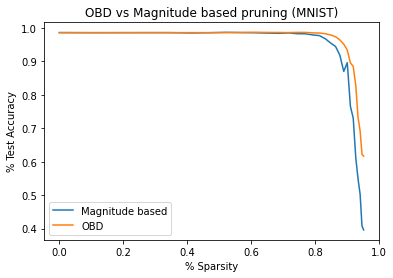

In [ ]:
plot_prune_histories(
    [mnist_prune_history, mnist_obd_history], 
    ['Magnitude based', 'OBD'], 
    title='OBD vs Magnitude based pruning (MNIST)'
)

OBD seems to perform a little better, but not really much.

### Fashion-MNIST

In [ ]:
fmnist_loader_full = DataLoader(
    fmnist_train,
    batch_size=len(fmnist_train)
)

In [ ]:
fmnist_model = torch.load('LeNet_FMNIST.pt').to(device)

In [ ]:
fmnist_loss = get_differentiable_loss(fmnist_model, loss_fn, fmnist_loader_full)

In [ ]:
fmnist_grad_dict = calculate_grads(fmnist_model, fmnist_loss)

In [ ]:
fmnist_hessian_diag = calculate_hessian_diags(fmnist_model, fmnist_grad_dict, print_every=500)

Calculating Hessian diagonal for module: conv1 with 54 values
Calculating Hessian diagonal for module: conv2 with 864 values
	idx 500/864
Calculating Hessian diagonal for module: fc1 with 48000 values
	idx 500/48000
	idx 1000/48000
	idx 1500/48000
	idx 2000/48000
	idx 2500/48000
	idx 3000/48000
	idx 3500/48000
	idx 4000/48000
	idx 4500/48000
	idx 5000/48000
	idx 5500/48000
	idx 6000/48000
	idx 6500/48000
	idx 7000/48000
	idx 7500/48000
	idx 8000/48000
	idx 8500/48000
	idx 9000/48000
	idx 9500/48000
	idx 10000/48000
	idx 10500/48000
	idx 11000/48000
	idx 11500/48000
	idx 12000/48000
	idx 12500/48000
	idx 13000/48000
	idx 13500/48000
	idx 14000/48000
	idx 14500/48000
	idx 15000/48000
	idx 15500/48000
	idx 16000/48000
	idx 16500/48000
	idx 17000/48000
	idx 17500/48000
	idx 18000/48000
	idx 18500/48000
	idx 19000/48000
	idx 19500/48000
	idx 20000/48000
	idx 20500/48000
	idx 21000/48000
	idx 21500/48000
	idx 22000/48000
	idx 22500/48000
	idx 23000/48000
	idx 23500/48000
	idx 24000/48000
	id

In [ ]:
fmnist_model = torch.load('LeNet_FMNIST.pt').to(device)

In [ ]:
# Calculate saliencies
fmnist_saliency_dict = calculate_saliencies(fmnist_model, fmnist_hessian_diag)

In [ ]:
# Apply OBD now
fmnist_obd_history = prune_gradually(
    fmnist_model, 
    SaliencyPruner, 
    fmnist_test_loader,
    importance_scores=fmnist_saliency_dict,
    prune_frac=0.1, 
    sparsity_threshold=0.05
)

At 10.00% sparsity, accuracy is 88.79%
At 19.00% sparsity, accuracy is 88.79%
At 27.10% sparsity, accuracy is 88.78%
At 34.39% sparsity, accuracy is 88.78%
At 40.95% sparsity, accuracy is 88.79%
At 46.85% sparsity, accuracy is 88.79%
At 52.17% sparsity, accuracy is 88.76%
At 56.95% sparsity, accuracy is 88.74%
At 61.26% sparsity, accuracy is 88.69%
At 65.13% sparsity, accuracy is 88.56%
At 68.62% sparsity, accuracy is 88.47%
At 71.75% sparsity, accuracy is 88.02%
At 74.58% sparsity, accuracy is 87.37%
At 77.12% sparsity, accuracy is 86.39%
At 79.41% sparsity, accuracy is 85.51%
At 81.47% sparsity, accuracy is 84.87%
At 83.32% sparsity, accuracy is 83.05%
At 84.99% sparsity, accuracy is 81.58%
At 86.49% sparsity, accuracy is 77.98%
At 87.84% sparsity, accuracy is 76.53%
At 89.05% sparsity, accuracy is 72.93%
At 90.15% sparsity, accuracy is 68.75%
At 91.13% sparsity, accuracy is 64.71%
At 92.02% sparsity, accuracy is 65.46%
At 92.82% sparsity, accuracy is 61.27%
At 93.53% sparsity, accur

In [ ]:
torch.save(fmnist_obd_history, 'fmnist_obd_history.pkl')

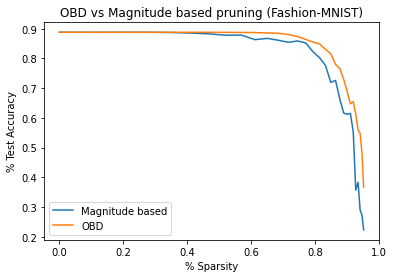

In [ ]:
# Plot prune histories for comparing magnitude based pruning and OBD
plot_prune_histories(
    [fmnist_prune_history, fmnist_obd_history], 
    ['Magnitude based', 'OBD'], 
    title='OBD vs Magnitude based pruning (Fashion-MNIST)'
)

### CIFAR10

In [ ]:
# For CIFAR10, we'll only use 20% of the whole dataset, since the GPU requrements get too high
cifar10_loader_full = DataLoader(
    cifar10_train,
    batch_size=len(cifar10_train)//5
)

In [ ]:
cifar10_model = torch.load('LeNet_CIFAR10.pt').to(device)

In [ ]:
cifar10_loss = get_differentiable_loss(cifar10_model, loss_fn, cifar10_loader_full)

In [ ]:
cifar10_grad_dict = calculate_grads(cifar10_model, cifar10_loss)

In [ ]:
cifar10_hessian_diag = calculate_hessian_diags(cifar10_model, cifar10_grad_dict, print_every=2000)

Calculating Hessian diagonal for module: conv1 with 162 values
Calculating Hessian diagonal for module: conv2 with 864 values
Calculating Hessian diagonal for module: fc1 with 69120 values
	idx 2000/69120
	idx 4000/69120
	idx 6000/69120
	idx 8000/69120
	idx 10000/69120
	idx 12000/69120
	idx 14000/69120
	idx 16000/69120
	idx 18000/69120
	idx 20000/69120
	idx 22000/69120
	idx 24000/69120
	idx 26000/69120
	idx 28000/69120
	idx 30000/69120
	idx 32000/69120
	idx 34000/69120
	idx 36000/69120
	idx 38000/69120
	idx 40000/69120
	idx 42000/69120
	idx 44000/69120
	idx 46000/69120
	idx 48000/69120
	idx 50000/69120
	idx 52000/69120
	idx 54000/69120
	idx 56000/69120
	idx 58000/69120
	idx 60000/69120
	idx 62000/69120
	idx 64000/69120
	idx 66000/69120
	idx 68000/69120
Calculating Hessian diagonal for module: fc2 with 10080 values
	idx 2000/10080
	idx 4000/10080
	idx 6000/10080
	idx 8000/10080
	idx 10000/10080
Calculating Hessian diagonal for module: fc3 with 840 values


In [ ]:
cifar10_saliency_dict = calculate_saliencies(cifar10_model, cifar10_hessian_diag)

In [ ]:
cifar10_obd_history = prune_gradually(
    cifar10_model, 
    SaliencyPruner, 
    cifar10_test_loader,
    importance_scores=cifar10_saliency_dict,
    prune_frac=0.1, 
    sparsity_threshold=0.05
)

At 10.00% sparsity, accuracy is 61.76%
At 19.00% sparsity, accuracy is 61.77%
At 27.10% sparsity, accuracy is 61.78%
At 34.39% sparsity, accuracy is 61.78%
At 40.95% sparsity, accuracy is 61.78%
At 46.85% sparsity, accuracy is 61.79%
At 52.17% sparsity, accuracy is 61.76%
At 56.95% sparsity, accuracy is 61.72%
At 61.25% sparsity, accuracy is 61.59%
At 65.13% sparsity, accuracy is 60.94%
At 68.61% sparsity, accuracy is 60.07%
At 71.75% sparsity, accuracy is 59.32%
At 74.58% sparsity, accuracy is 59.18%
At 77.12% sparsity, accuracy is 58.91%
At 79.41% sparsity, accuracy is 57.81%
At 81.46% sparsity, accuracy is 56.51%
At 83.32% sparsity, accuracy is 53.87%
At 84.99% sparsity, accuracy is 52.39%
At 86.49% sparsity, accuracy is 50.53%
At 87.84% sparsity, accuracy is 47.65%
At 89.05% sparsity, accuracy is 44.80%
At 90.15% sparsity, accuracy is 43.45%
At 91.13% sparsity, accuracy is 37.92%
At 92.02% sparsity, accuracy is 32.22%
At 92.82% sparsity, accuracy is 26.71%
At 93.53% sparsity, accur

In [ ]:
cifar10_prune_history = torch.load('cifar10_prune_history.pkl')

In [ ]:
torch.save(cifar10_obd_history, 'cifar10_obd_history.pkl')

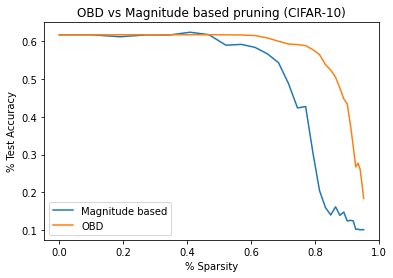

In [ ]:
# Plot prune histories for comparing magnitude based pruning and OBD
plot_prune_histories(
    [cifar10_prune_history, cifar10_obd_history], 
    ['Magnitude based', 'OBD'], 
    title='OBD vs Magnitude based pruning (CIFAR-10)'
)

Even with saliencies calculated using just 20% of the dataset, OBD is able to significantly outperform magnitude based pruning in case of CIFAR10.

## Iterative Pruning

In this section, we'll implement the iterative pruning method proposed by Han et. al. (2015). In this method, we first take a trained network, and then each iteration involves pruning and subsequent retraining of the weights in the pruned network.

### Pruning function

In [ ]:
def iterative_pruning(model, method, n_iters, train_loader, test_loader, opt_fn=optim.Adam, loss_fn=F.cross_entropy, lr=0.001, prune_frac=0.2, train_epochs=10, sparsity_threshold=0.99, importance_scores=None):
  history = []
  history.append((0, test_accuracy(model, test_loader)))
  
  parameters_to_prune = get_parameters_to_prune(model)
  for iter in range(n_iters):
    # Prune
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=method,
        importance_scores=importance_scores,
        amount=prune_frac,  
    )

    # Retrain
    fit(model, train_loader, train_epochs, opt_fn, loss_fn, lr=lr, print_every=1000000)

    acc = test_accuracy(model, test_loader)
    sparsity = calculate_sparsity(model)
    print(f"Iteration [{iter+1}/{n_iters}]: Sparsity: {100*sparsity:.2f}%, Accuracy: {100*acc:.2f}%")
    history.append((sparsity, acc))

    if sparsity >= sparsity_threshold:
      print('Sparsity threshold (%.2f'%(sparsity_threshold*100) + '%) reached, stopping.')
      break

  return history

### MNIST

In [ ]:
mnist_model = torch.load('LeNet_MNIST.pt').to(device)

We'll prune 20% each time, and then retrain the model for 10 epochs.

In [ ]:
# Prune for 25 iterations, or until sparsity threshold is reached
mnist_ip_history = iterative_pruning(mnist_model, MyL1PruningMethod, 25, mnist_train_loader, mnist_test_loader)

Iteration [1/25]: Sparsity: 20.00%, Accuracy: 98.52%
Iteration [2/25]: Sparsity: 36.00%, Accuracy: 98.83%
Iteration [3/25]: Sparsity: 48.80%, Accuracy: 98.87%
Iteration [4/25]: Sparsity: 59.04%, Accuracy: 98.94%
Iteration [5/25]: Sparsity: 67.23%, Accuracy: 98.90%
Iteration [6/25]: Sparsity: 73.78%, Accuracy: 98.84%
Iteration [7/25]: Sparsity: 79.03%, Accuracy: 98.83%
Iteration [8/25]: Sparsity: 83.22%, Accuracy: 98.88%
Iteration [9/25]: Sparsity: 86.58%, Accuracy: 98.90%
Iteration [10/25]: Sparsity: 89.26%, Accuracy: 98.70%
Iteration [11/25]: Sparsity: 91.41%, Accuracy: 98.71%
Iteration [12/25]: Sparsity: 93.12%, Accuracy: 98.71%
Iteration [13/25]: Sparsity: 94.50%, Accuracy: 98.47%
Iteration [14/25]: Sparsity: 95.60%, Accuracy: 98.59%
Iteration [15/25]: Sparsity: 96.48%, Accuracy: 98.40%
Iteration [16/25]: Sparsity: 97.18%, Accuracy: 98.22%
Iteration [17/25]: Sparsity: 97.74%, Accuracy: 97.89%
Iteration [18/25]: Sparsity: 98.20%, Accuracy: 97.16%
Iteration [19/25]: Sparsity: 98.56%, 

In [ ]:
torch.save(mnist_ip_history, 'mnist_ip_history.pkl')

Let's plot the dropoff in accuracy.

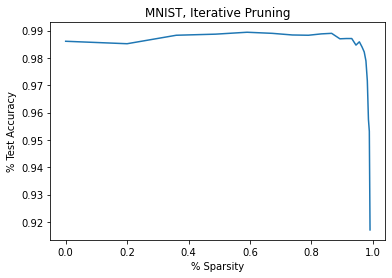

In [ ]:
plot_prune_histories([mnist_ip_history], ['MNIST'], title='MNIST, Iterative Pruning')

For lower sparsity values, the pruned network seems to perform better than the original trained network! No significant drop in accuracy occurs, even after we've pruned ~95% of the weights. Even at 98% sparsity, the accuracy is respectable.

### Fashion-MNIST

In [ ]:
fmnist_model = torch.load('LeNet_FMNIST.pt').to(device)

In [ ]:
fmnist_ip_history = iterative_pruning(fmnist_model, MyL1PruningMethod, 25, fmnist_train_loader, fmnist_test_loader)

Iteration [1/25]: Sparsity: 20.00%, Accuracy: 88.28%
Iteration [2/25]: Sparsity: 36.00%, Accuracy: 88.62%
Iteration [3/25]: Sparsity: 48.80%, Accuracy: 88.19%
Iteration [4/25]: Sparsity: 59.04%, Accuracy: 87.73%
Iteration [5/25]: Sparsity: 67.23%, Accuracy: 88.39%
Iteration [6/25]: Sparsity: 73.78%, Accuracy: 88.46%
Iteration [7/25]: Sparsity: 79.03%, Accuracy: 88.73%
Iteration [8/25]: Sparsity: 83.22%, Accuracy: 88.16%
Iteration [9/25]: Sparsity: 86.58%, Accuracy: 88.67%
Iteration [10/25]: Sparsity: 89.26%, Accuracy: 89.06%
Iteration [11/25]: Sparsity: 91.41%, Accuracy: 88.92%
Iteration [12/25]: Sparsity: 93.12%, Accuracy: 88.90%
Iteration [13/25]: Sparsity: 94.50%, Accuracy: 88.67%
Iteration [14/25]: Sparsity: 95.60%, Accuracy: 88.55%
Iteration [15/25]: Sparsity: 96.48%, Accuracy: 88.01%
Iteration [16/25]: Sparsity: 97.18%, Accuracy: 87.64%
Iteration [17/25]: Sparsity: 97.74%, Accuracy: 86.53%
Iteration [18/25]: Sparsity: 98.20%, Accuracy: 85.36%
Iteration [19/25]: Sparsity: 98.56%, 

In [ ]:
torch.save(fmnist_ip_history, 'fmnist_ip_history.pkl')

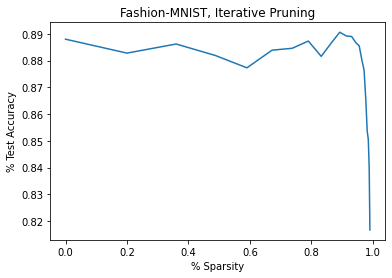

In [ ]:
plot_prune_histories([fmnist_ip_history], ['Fashion-MNIST'], title='Fashion-MNIST, Iterative Pruning')

Similar output, but there are some valleys in there. This could be because 10 training epochs were not enough.

### CIFAR10

In [ ]:
cifar10_model = torch.load('LeNet_CIFAR10.pt').to(device)

Since CIFAR-10 seems to be a harder dataset, we'll train for 20 epochs after each pruning iteration

In [ ]:
cifar10_ip_history = iterative_pruning(
    cifar10_model, 
    MyL1PruningMethod, 
    25, 
    cifar10_train_loader, 
    cifar10_test_loader, 
    train_epochs=20
)

Iteration [1/25]: Sparsity: 20.00%, Accuracy: 60.45%
Iteration [2/25]: Sparsity: 36.00%, Accuracy: 59.71%
Iteration [3/25]: Sparsity: 48.80%, Accuracy: 58.85%
Iteration [4/25]: Sparsity: 59.04%, Accuracy: 58.26%
Iteration [5/25]: Sparsity: 67.23%, Accuracy: 57.36%
Iteration [6/25]: Sparsity: 73.78%, Accuracy: 57.94%
Iteration [7/25]: Sparsity: 79.03%, Accuracy: 58.37%
Iteration [8/25]: Sparsity: 83.22%, Accuracy: 59.64%
Iteration [9/25]: Sparsity: 86.58%, Accuracy: 60.24%
Iteration [10/25]: Sparsity: 89.26%, Accuracy: 61.08%
Iteration [11/25]: Sparsity: 91.41%, Accuracy: 61.62%
Iteration [12/25]: Sparsity: 93.13%, Accuracy: 60.91%
Iteration [13/25]: Sparsity: 94.50%, Accuracy: 60.27%
Iteration [14/25]: Sparsity: 95.60%, Accuracy: 58.96%
Iteration [15/25]: Sparsity: 96.48%, Accuracy: 57.86%
Iteration [16/25]: Sparsity: 97.18%, Accuracy: 55.53%
Iteration [17/25]: Sparsity: 97.75%, Accuracy: 53.15%
Iteration [18/25]: Sparsity: 98.20%, Accuracy: 52.31%
Iteration [19/25]: Sparsity: 98.56%, 

In [ ]:
torch.save(cifar10_ip_history, 'cifar10_ip_history.pkl')

Just for comparison, we'll plot the results from magnitude based pruning and OBD as well.

In [40]:
cifar10_ip_history = torch.load('cifar10_ip_history.pkl')
cifar10_prune_history = torch.load('cifar10_prune_history.pkl')
cifar10_obd_history = torch.load('cifar10_obd_history.pkl')

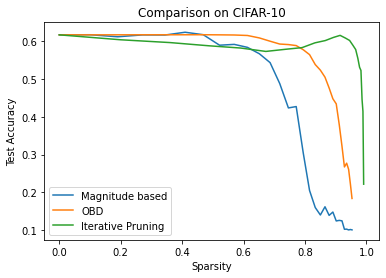

In [41]:
plot_prune_histories(
    [cifar10_prune_history, cifar10_obd_history, cifar10_ip_history], 
    ['Magnitude based', 'OBD', 'Iterative Pruning'], 
    title='Comparison on CIFAR-10'
)

Iterative pruning seems to be underperforming for lower sparsity values. This is weird. 

## The Lottery Ticket Hypothesis

The lottery ticket hypothesis (proposed by Frankle and Carbin, 2019) states that, at initialization, dense neural networks contain sparse subnetworks which can be trained to achieve performance similar to or better than the original dense networks. Such sparse trainable subnetworks are called _winning tickets_.

Frankle and Carbin proposed a method to search winning tickets, called Iterative Magnitude Pruning (IMP). It is very similar to the iterative pruning method we've seen, except at each iteration, the weights of the remaining subnetwork are reset back to their initial values.

### Function for pruning, reinitialization, and retraining

Here is an implementation of the Iterative Magnitude Pruning (IMP) method that Frankle and Carbin demonstrated to be able to find very sparse lottery tickets. This will be very similar to the iterative pruning method, except we will be resetting the remaining weights to their values at initialization.

In [15]:
def imp(model, method, n_iters, train_loader, test_loader, opt_fn=optim.Adam, loss_fn=F.cross_entropy, lr=0.001, prune_frac=0.2, train_epochs=10, sparsity_threshold=0.99, importance_scores=None):
  history = []

  # Save initial weights
  weight_dict = {}
  for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        weight_dict[name+'.weight'] = copy.deepcopy(module.weight.data)
  
  parameters_to_prune = get_parameters_to_prune(model)
  for iter in range(n_iters):
    # Train
    fit(model, train_loader, train_epochs, opt_fn, loss_fn, lr=lr, print_every=1000000)

    acc = test_accuracy(model, test_loader)
    sparsity = calculate_sparsity(model)
    print(f"Iteration [{iter+1}/{n_iters}]: Sparsity: {100*sparsity:.2f}%, Accuracy: {100*acc:.2f}%")
    history.append((sparsity, acc))

    
    # Prune
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=method,
        importance_scores=importance_scores,
        amount=prune_frac,  
    )

    # Reset weights
    for name, module in model.named_modules():
      if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        module.weight_orig.data.copy_(weight_dict[name+'.weight'].data)

    if sparsity >= sparsity_threshold:
      print('Sparsity threshold (%.2f'%(sparsity_threshold*100) + '%) reached, stopping.')
      break

  return history

### MNIST

In [ ]:
mnist_model = LeNet5(1, 28).to(device)

In [ ]:
mnist_lth_history = imp(mnist_model, MyL1PruningMethod, 25, mnist_train_loader, mnist_test_loader)

Iteration [1/25]: Sparsity: 0.00%, Accuracy: 98.85%
Iteration [2/25]: Sparsity: 20.00%, Accuracy: 98.65%
Iteration [3/25]: Sparsity: 36.00%, Accuracy: 98.64%
Iteration [4/25]: Sparsity: 48.80%, Accuracy: 98.79%
Iteration [5/25]: Sparsity: 59.04%, Accuracy: 98.77%
Iteration [6/25]: Sparsity: 67.23%, Accuracy: 98.77%
Iteration [7/25]: Sparsity: 73.78%, Accuracy: 98.73%
Iteration [8/25]: Sparsity: 79.03%, Accuracy: 98.71%
Iteration [9/25]: Sparsity: 83.22%, Accuracy: 98.66%
Iteration [10/25]: Sparsity: 86.58%, Accuracy: 98.69%
Iteration [11/25]: Sparsity: 89.26%, Accuracy: 98.77%
Iteration [12/25]: Sparsity: 91.41%, Accuracy: 98.86%
Iteration [13/25]: Sparsity: 93.12%, Accuracy: 98.80%
Iteration [14/25]: Sparsity: 94.50%, Accuracy: 98.66%
Iteration [15/25]: Sparsity: 95.60%, Accuracy: 98.62%
Iteration [16/25]: Sparsity: 96.48%, Accuracy: 98.38%
Iteration [17/25]: Sparsity: 97.18%, Accuracy: 98.25%
Iteration [18/25]: Sparsity: 97.74%, Accuracy: 97.96%
Iteration [19/25]: Sparsity: 98.20%, A

In [ ]:
torch.save(mnist_lth_history, 'mnist_lth_history.pkl')

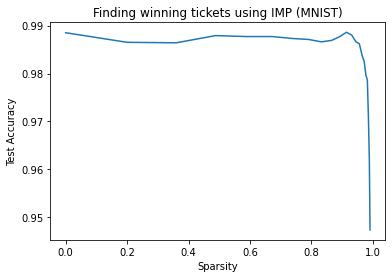

In [ ]:
plot_prune_histories([mnist_lth_history], ['MNIST'], title='Finding winning tickets using IMP (MNIST)')

### Fashion-MNIST

In [16]:
fmnist_model = LeNet5(1, 28).to(device)

In [22]:
fmnist_lth_history = imp(fmnist_model, MyL1PruningMethod, 25, fmnist_train_loader, fmnist_test_loader)

Iteration [1/25]: Sparsity: 0.00%, Accuracy: 88.23%
Iteration [2/25]: Sparsity: 20.00%, Accuracy: 88.48%
Iteration [3/25]: Sparsity: 36.00%, Accuracy: 88.16%
Iteration [4/25]: Sparsity: 48.80%, Accuracy: 88.47%
Iteration [5/25]: Sparsity: 59.04%, Accuracy: 88.58%
Iteration [6/25]: Sparsity: 67.23%, Accuracy: 88.55%
Iteration [7/25]: Sparsity: 73.78%, Accuracy: 88.88%
Iteration [8/25]: Sparsity: 79.03%, Accuracy: 88.96%
Iteration [9/25]: Sparsity: 83.22%, Accuracy: 88.84%
Iteration [10/25]: Sparsity: 86.58%, Accuracy: 88.65%
Iteration [11/25]: Sparsity: 89.26%, Accuracy: 88.54%
Iteration [12/25]: Sparsity: 91.41%, Accuracy: 88.65%
Iteration [13/25]: Sparsity: 93.12%, Accuracy: 88.44%
Iteration [14/25]: Sparsity: 94.50%, Accuracy: 88.37%
Iteration [15/25]: Sparsity: 95.60%, Accuracy: 88.13%
Iteration [16/25]: Sparsity: 96.48%, Accuracy: 87.81%
Iteration [17/25]: Sparsity: 97.18%, Accuracy: 87.02%
Iteration [18/25]: Sparsity: 97.74%, Accuracy: 86.54%
Iteration [19/25]: Sparsity: 98.20%, A

In [23]:
torch.save(fmnist_lth_history, 'fmnist_lth_history.pkl')

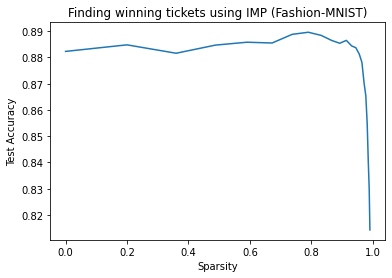

In [26]:
plot_prune_histories([fmnist_lth_history], ['Fashion-MNIST'], title='Finding winning tickets using IMP (Fashion-MNIST)')

### CIFAR-10

In [27]:
cifar10_model = LeNet5(3, 32).to(device)

Since CIFAR-10 is a harder dataset, we'll give 15 training epoch after each pruning iteration.

In [29]:
cifar10_lth_history = imp(
    cifar10_model, 
    MyL1PruningMethod, 
    25, 
    cifar10_train_loader, 
    cifar10_test_loader, 
    train_epochs=15
)

Iteration [1/25]: Sparsity: 0.00%, Accuracy: 61.48%
Iteration [2/25]: Sparsity: 20.00%, Accuracy: 60.68%
Iteration [3/25]: Sparsity: 36.00%, Accuracy: 59.56%
Iteration [4/25]: Sparsity: 48.80%, Accuracy: 59.94%
Iteration [5/25]: Sparsity: 59.04%, Accuracy: 59.93%
Iteration [6/25]: Sparsity: 67.23%, Accuracy: 59.91%
Iteration [7/25]: Sparsity: 73.78%, Accuracy: 58.98%
Iteration [8/25]: Sparsity: 79.03%, Accuracy: 58.18%
Iteration [9/25]: Sparsity: 83.22%, Accuracy: 56.66%
Iteration [10/25]: Sparsity: 86.58%, Accuracy: 56.09%
Iteration [11/25]: Sparsity: 89.26%, Accuracy: 57.00%
Iteration [12/25]: Sparsity: 91.41%, Accuracy: 54.51%
Iteration [13/25]: Sparsity: 93.13%, Accuracy: 54.96%
Iteration [14/25]: Sparsity: 94.50%, Accuracy: 52.27%
Iteration [15/25]: Sparsity: 95.60%, Accuracy: 51.82%
Iteration [16/25]: Sparsity: 96.48%, Accuracy: 51.55%
Iteration [17/25]: Sparsity: 97.18%, Accuracy: 51.19%
Iteration [18/25]: Sparsity: 97.75%, Accuracy: 51.17%
Iteration [19/25]: Sparsity: 98.20%, A

In [33]:
torch.save(cifar10_lth_history, 'cifar10_lth_history.pkl')

In [35]:
cifar10_lth_history

[(0.0, 0.6148),
 (0.199997532874448, 0.6068),
 (0.35999062492290235, 0.5956),
 (0.4879850985616658, 0.5994),
 (0.5903831445982286, 0.5993),
 (0.6723040485530308, 0.5991),
 (0.7378432388424246, 0.5898),
 (0.7902696568228357, 0.5818),
 (0.8322107912071646, 0.5666),
 (0.8657636987146275, 0.5609),
 (0.892606024720598, 0.57),
 (0.9140823526509264, 0.5451),
 (0.9312658821207411, 0.5496),
 (0.9450077714454889, 0.5227),
 (0.955998815779735, 0.5182),
 (0.964794118372684, 0.5155),
 (0.9718254261959391, 0.5119),
 (0.9774504724545432, 0.5117),
 (0.9819529765869786, 0.5064),
 (0.9855549798929267, 0.4997),
 (0.9884415167887893, 0.501),
 (0.9907482791799275, 0.4641)]

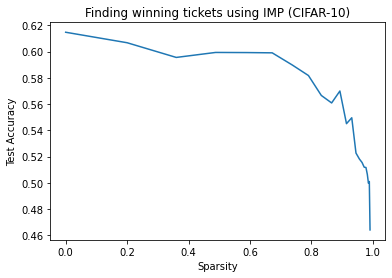

In [34]:
plot_prune_histories(
    [cifar10_lth_history], 
    ['CIFAR-10'], 
    title='Finding winning tickets using IMP (CIFAR-10)'
)

This time, it was we couldn't find very sparse tickets that matched the original network's performance. This might be because we need to put in more training iterations after each pruning iteration, since LeNet is pretty slow to train on CIFAR-10. Regardless, we can see that the subnetworks we get have a performance close enough to the original network (61.9% vs 59.9% accuracy at 67% sparsity).

Overall the results on CIFAR-10 are inconclusive, but hint at the need for a larger architecture.

### All three

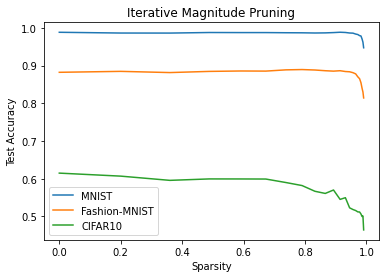

In [39]:
# Let's plot the performance of IMP for all three datasets
plot_prune_histories(
    [mnist_lth_history, fmnist_lth_history, cifar10_lth_history], 
    ['MNIST', 'Fashion-MNIST', 'CIFAR10'], 
    title='Iterative Magnitude Pruning'
)

## Conclusions

We saw implementations of magnitude based pruning, Optimal Brain Damage, and iterative pruning. For single-shot pruning, Optimal Brain Damage performed consistently better than magnitude based pruning. However, because of the way gradients are calculated in PyTorch, it is currently prohibitively expensive. Iterative pruning far outperforms either of these techniques, but needs a huge amount of time.

From the graphs we plotted, at least for MNIST and Fashion-MNIST, it seems that even at 97% sparsity, the _tickets_ we found have performance close to the unpruned model in terms of test accuracy in 10 epochs of training. Hence, at least for this setting and the limited number of epochs we put in, it seems that the lottery ticket hypothesis holds a lot of promise.